In [1]:
# download InferSent sentence encoder and GloVe vectors
!git clone https://github.com/facebookresearch/InferSent
!cp -r ./InferSent/* .
!mkdir -p dataset/GloVe
!curl -Lo encoder/infersent1.pickle https://dl.fbaipublicfiles.com/senteval/infersent/infersent1.pkl
!curl -Lo dataset/GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip dataset/GloVe/glove.840B.300d.zip -d dataset/GloVe/

Cloning into 'InferSent'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 238 (delta 5), reused 5 (delta 1), pack-reused 222
Receiving objects: 100% (238/238), 445.59 KiB | 1.29 MiB/s, done.
Resolving deltas: 100% (117/117), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  10.0M      0  0:00:14  0:00:14 --:--:-- 11.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2075M  100 2075M    0     0  5912k      0  0:05:59  0:05:59 --:--:-- 10.1M
Archive:  dataset/GloVe/glove.840B.300d.zip
  inflating: dataset/GloVe/glove.840B.300d.txt  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Today's data

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with.

You won't have to deal with low-level text processing tasks. It's only about deep learning. And it's gonna be a breeze!

In [3]:
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/fecdbfa974819a6656737569b2b2aed738a1b979/week02_classification/comments.tsv -O comments.tsv
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values

tokenizer = nltk.WordPunctTokenizer()
data['comment_text'] = data['comment_text'].apply(
    lambda sent: ' '.join(tokenizer.tokenize(sent.lower().replace('\n', ' ')))
)

data[50::200]

--2019-04-23 17:42:27--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/fecdbfa974819a6656737569b2b2aed738a1b979/week02_classification/comments.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353358 (345K) [text/plain]
Saving to: ‘comments.tsv’

comments.tsv        100%[===================>] 345.08K  --.-KB/s    in 0.02s   

2019-04-23 17:42:27 (15.8 MB/s) - ‘comments.tsv’ saved [353358/353358]



,should_ban,comment_text
50,0,""" those who ' re in advantageous positions are..."
250,1,fartsalot56 says f ** k you motherclucker !!
450,1,"are you a fool ? i am sorry , but you seem to ..."
650,1,i am not a vandal !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,citing sources check out the wikipedia : citin...


### InferSent

We are going to use a pre-trained InferSent model: a bidirectional LSTM that was trained for a range of supervised tasks:
![image.png](attachment:image.png)

This model is but one of many "NLP model zoo" exhibits. The only reason we picked it was because it was the simplest one to use in pytorch.

In [4]:
# Load infersent model
from models import InferSent
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': 1}
model = InferSent(params_model)
model.load_state_dict(torch.load("./encoder/infersent1.pickle"))
model.set_w2v_path('./dataset/GloVe/glove.840B.300d.txt')
model.build_vocab_k_words(K=100000)

Vocab size : 100000


Here's how you can encode data into vector space. InferSent returns 4096-dimensional activations from the last layer.

In [5]:
sentences = sorted(data.comment_text.tolist(), key=len)[200:210]

embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)

print('embeddings shape:', embeddings.shape)

Nb words kept : 152/156 (97.4%)
Speed : 13.1 sentences/s (cpu mode, bsize=128)
embeddings shape: (10, 4096)


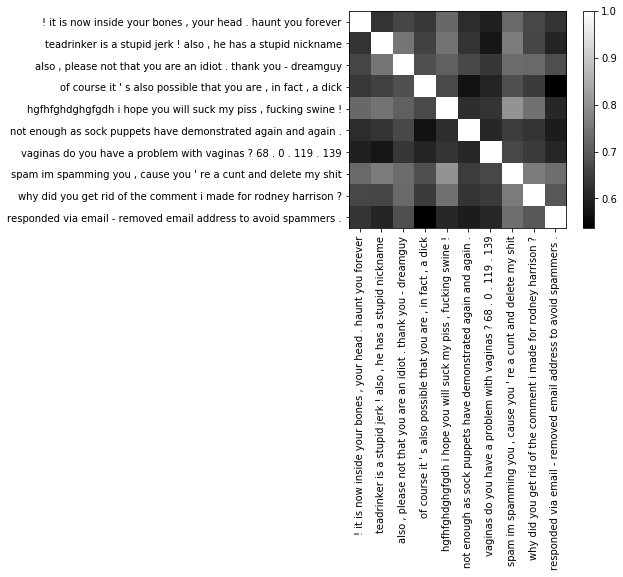

In [6]:
def cosine_similarity(embeddings):
    dot = (embeddings[None, :, :] * embeddings[:, None, :]).sum(-1)
    norms = np.sqrt(np.square(embeddings).sum(-1))
    return dot / norms[None, :] / norms[:, None]


plt.imshow(cosine_similarity(embeddings), cmap='gray')
plt.yticks(np.arange(len(sentences)), sentences);
plt.xticks(np.arange(len(sentences)), sentences, rotation=90);
plt.colorbar();

In [8]:
from sklearn.manifold import TSNE
sentences = data.comment_text.tolist()
targets = data.should_ban.values

embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)

emb_2d = TSNE(n_components=2,verbose=True).fit_transform(embeddings) # <learn 2d representation for :embeddings: with TSNE>
assert emb_2d.shape == (len(embeddings), 2)

Nb words kept : 71139/76247 (93.3%)
Speed : 6.7 sentences/s (cpu mode, bsize=128)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.109s...
[t-SNE] Computed neighbors for 1000 samples in 8.749s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.640226
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.678734
[t-SNE] KL divergence after 1000 iterations: 1.415506


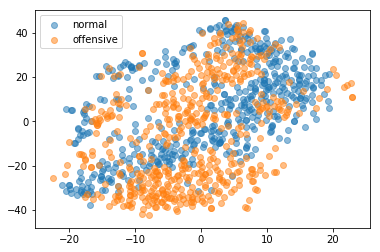

In [9]:
plt.scatter(*emb_2d[targets == 0].T, label='normal', alpha=0.5)
plt.scatter(*emb_2d[targets == 1].T, label='offensive', alpha=0.5)
plt.legend(loc='best')

### And now, let's classify

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

<YOUR CODE HERE>

# make k >= 5-fold cross validation and print how well it performs

### Learn more:
* Finding similar questions with Universal Sentence Encoder: [notebook](https://github.com/yandexdataschool/nlp_course/tree/master/week10_dialogue)
* Generating stories with pre-trained BERT: [open in colab](https://colab.research.google.com/drive/1MxKZGtQ9SSBjTK5ArsZ5LKhkztzg52RV)
* Semantic search engine with ELMO: [open in colab](https://colab.research.google.com/drive/13f6dKakC-0yO6_DxqSqo0Kl41KMHT8A1)



